In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def best_output(row):
    # se o downloadTime é diferente de 100 para T2 e T3, ambos os targets completam o download
    if ((row.downloadTimeT2!=100)&(row.downloadTimeT3!=100)):
        # o melhor output será aquele para o qual o downloadTime é menor
        if (row.downloadTimeT2<=row.downloadTimeT3):
            return 0
        else:
            return 1
    
    # se o downloadTime é diferente de 100 apenas para um dos targets, só um deles completa o download
    elif ((row.downloadTimeT2!=100)|(row.downloadTimeT3!=100)):
        # o melhor output será aquele para o qual o downloadTime é diferente de 100
        if (row.downloadTimeT2!=100):
            return 0
        else:
            return 1
        
    # se o downloadTime é igual a 100 para T2 e T3, ambos os targets não completam o download
    elif ((row.downloadTimeT2==100)&(row.downloadTimeT3==100)):
        # o melhor output será aquele para o qual o rxBytes é maior
        if (row.rxBytesT2>=row.rxBytesT3):
            return 0
        else:
            return 1

In [4]:
def download_complete(row, column):
    if (row[column]==0):
        if(row.downloadTimeT2!=100.0):
            return 1
        else:
            return 0
    else:
        if(row.downloadTimeT3!=100.0):
            return 1
        else: 
            return 0

        
def download_time(row, column):
    if ((row[column]==0)&(row.downloadTimeT2<100)):
        return row.downloadTimeT2
    elif ((row[column]==1)&(row.downloadTimeT3<100)):
        return row.downloadTimeT3

    
def throughput(row, column):
    if (row[column]==0):
        tp = (row.rxBytesT2/row.downloadTimeT2)*8/1e6
        return tp
    else:
        tp = (row.rxBytesT3/row.downloadTimeT3)*8/1e6
        return tp

In [5]:
def optimum_choice(row, column):
    if (row[column]==row.best_output):
        return 1
    else:
        return 0

In [6]:
def a2a4rsrp(row):
    if (row.rsrp2>=row.rsrp3):
        return 0
    else:
        return 1

# Sem Shadowing

In [1]:
# importando os datasets
t2 = pd.read_csv('resultados/t2_OkumuraHata_Modificado', delimiter='\t')
t3 = pd.read_csv('resultados/t3_OkumuraHata_Modificado', delimiter='\t')

# garantindo que utilizaremos apenas as sementes presentes nos dois datasets
t2 = t2[t2.nRun.isin(t3.nRun)]
t3 = t3[t3.nRun.isin(t2.nRun)]
t2 = t2.reset_index(drop=True)
t3 = t3.reset_index(drop=True)

# combinando os datasets
data = t2
data = data.drop(['targetCellId', 'downloadTime', 'rxBytes'], axis=1)
data['downloadTimeT2'] = t2.downloadTime
data['downloadTimeT3'] = t3.downloadTime
data['rxBytesT2'] = t2.rxBytes
data['rxBytesT3'] = t3.rxBytes

from ho_func import rsrp_value, rsrq_value

data['rsrp1'] = data.rsrp1.apply(rsrp_value)
data['rsrp2'] = data.rsrp2.apply(rsrp_value)
data['rsrp3'] = data.rsrp3.apply(rsrp_value)
data['previousrsrp1'] = data.previousrsrp1.apply(rsrp_value)
data['previousrsrp2'] = data.previousrsrp2.apply(rsrp_value)
data['previousrsrp3'] = data.previousrsrp3.apply(rsrp_value)
data['rsrq1'] = data.rsrq1.apply(rsrq_value)
data['rsrq2'] = data.rsrq2.apply(rsrq_value)
data['rsrq3'] = data.rsrq3.apply(rsrq_value)
data['previousrsrq1'] = data.previousrsrq1.apply(rsrq_value)
data['previousrsrq2'] = data.previousrsrq2.apply(rsrq_value)
data['previousrsrq3'] = data.previousrsrq3.apply(rsrq_value)

# normalize
original_data = data
data = (data - data.mean()) / (data.std())
data[['nRun','angle','downloadTimeT2','downloadTimeT3','rxBytesT2','rxBytesT3','best_output']] = original_data[['nRun','angle','downloadTimeT2','downloadTimeT3','rxBytesT2','rxBytesT3','best_output']]

data['best_output'] = data.apply(best_output, axis=1)
data.head()

NameError: name 'pd' is not defined

In [ ]:
teste = data[data.nRun>800]
data = data[data.nRun<=800]

In [ ]:
import seaborn as sns
features = data[['rsrp1','rsrq1','rsrp2','rsrq2','rsrp3','rsrq3','previousrsrp1','previousrsrq1','previousrsrp2','previousrsrq2','previousrsrp3','previousrsrq3','best_output']]
features = features.rename(columns={'rsrp1': 'RSRP eNB 1', 'rsrq1': 'RSRQ eNB 1', 'rsrp2': 'RSRP eNB 2', 'rsrq2': 'RSRQ eNB 2', 'rsrp3': 'RSRP eNB 3', 'rsrq3': 'RSRQ eNB 3', 'previousrsrp1': 'RSRP eNB 1 (anterior)', 'previousrsrq1': 'RSRQ eNB 1 (anterior)', 'previousrsrp2': 'RSRP eNB 2 (anterior)', 'previousrsrq2': 'RSRQ eNB 2 (anterior)', 'previousrsrp3': 'RSRP eNB 3 (anterior)', 'previousrsrq3': 'RSRQ eNB 3 (anterior)', 'best_output': 'Melhor Target'})
sns.heatmap(features.corr())

In [ ]:
param_test = {'hidden_layer_sizes': [(i) for i in range(1,101)]}

### Estratégia 1

In [ ]:
# A: Download Completo ou Incompleto (para todas as amostras)
nn1_a_input = data[['rsrp1','rsrq1','rsrp2','rsrq2','rsrp3','rsrq3','previousrsrp1','previousrsrq1','previousrsrp2','previousrsrq2','previousrsrp3','previousrsrq3']]

# NN A para T2
nn1_a0_output = (data.downloadTimeT2<100).astype(int)
nn1_a0 = GridSearchCV(estimator=MLPClassifier(solver='lbfgs', random_state=1, validation_fraction=0.25), param_grid=param_test, cv=5, scoring='roc_auc')
nn1_a0.fit(nn1_a_input.as_matrix(), nn1_a0_output);

print (nn1_a0.best_params_)
print ((nn1_a0.predict(nn1_a_input)==(data.downloadTimeT2<100).astype(int)).sum()/data.shape[0])

# NN A para T3
nn1_a1_output = (data.downloadTimeT3<100).astype(int)
nn1_a1 = GridSearchCV(estimator=MLPClassifier(solver='lbfgs', random_state=1, validation_fraction=0.25), param_grid=param_test, cv=5, scoring='roc_auc')
nn1_a1.fit(nn1_a_input.as_matrix(), nn1_a1_output);

print (nn1_a1.best_params_)
print ((nn1_a1.predict(nn1_a_input)==(data.downloadTimeT3<100).astype(int)).sum()/data.shape[0])

In [ ]:
# B: Tempo de Download (para amostras em que ambos os targets completam o download)
nn1_b_input = data[(data.downloadTimeT2<100)&(data.downloadTimeT3<100)][['rsrp1','rsrq1','rsrp2','rsrq2','rsrp3','rsrq3','previousrsrp1','previousrsrq1','previousrsrp2','previousrsrq2','previousrsrp3','previousrsrq3']]
# NN B para T2
nn1_b0_output = data[(data.downloadTimeT2<100)&(data.downloadTimeT3<100)].downloadTimeT2
nn1_b0 = GridSearchCV(estimator=MLPRegressor(solver='lbfgs', random_state=1, validation_fraction=0.25), param_grid=param_test, cv=5)
nn1_b0.fit(nn1_b_input.as_matrix(), nn1_b0_output);

print (nn1_b0.best_params_)
print (mean_squared_error(nn1_b0.predict(nn1_b_input),data[(data.downloadTimeT2<100)&(data.downloadTimeT3<100)].downloadTimeT2))

# NN B para T3
nn1_b1_output = data[(data.downloadTimeT2<100)&(data.downloadTimeT3<100)].downloadTimeT3
nn1_b1 = GridSearchCV(estimator=MLPRegressor(solver='lbfgs', random_state=1, validation_fraction=0.25), param_grid=param_test, cv=5)
nn1_b1.fit(nn1_b_input.as_matrix(), nn1_b1_output);

print (nn1_b1.best_params_)
print (mean_squared_error(nn1_b1.predict(nn1_b_input),data[(data.downloadTimeT2<100)&(data.downloadTimeT3<100)].downloadTimeT3))

In [ ]:
def nn1_func(row):
    nn1_input = row[['rsrp1','rsrq1','rsrp2','rsrq2','rsrp3','rsrq3','previousrsrp1','previousrsrq1','previousrsrp2','previousrsrq2','previousrsrp3','previousrsrq3']].values.reshape(1, -1)
    # Nível 1A
    # se o downloadTime previsto é menor que 100 para T2 e T3, ambos os targets completam o download
    if ((nn1_a0.predict(nn1_input)==1)&(nn1_a1.predict(nn1_input)==1)):
        # Nível 2B
        # o melhor output será aquele para o qual o downloadTime previsto é menor
        if (nn1_b0.predict(nn1_input)<=nn1_b1.predict(nn1_input)):
            return 0
        else:
            return 1
    
    # se o downloadTime previsto é menor que 100 apenas para um dos targets, só um deles completa o download
    elif ((nn1_a0.predict(nn1_input)==1)|(nn1_a1.predict(nn1_input)==1)):
        # o melhor output será aquele para o qual o downloadTime previsto é menor que 100
        if (nn1_a0.predict(nn1_input)==1):
            return 0
        else:
            return 1
  
        
((nn1_a_input.apply(nn1_func, axis=1)==data.best_output).sum())/data.best_output.size        

### Estratégia 2

In [ ]:
# A: Download Completo ou Incompleto (para todas as amostras)

# NN A para T2
nn2_a0_input = data[['rsrp2','rsrq2','previousrsrp2','previousrsrq2']]
nn2_a0_output = (data.downloadTimeT2<100).astype(int)
nn2_a0 = GridSearchCV(estimator=MLPClassifier(solver='lbfgs', random_state=1, validation_fraction=0.25), param_grid=param_test, scoring='roc_auc', cv=5)
nn2_a0.fit(nn2_a0_input.as_matrix(), nn2_a0_output);

print (nn2_a0.best_params_)
print ((nn2_a0.predict(nn2_a0_input)==(data.downloadTimeT2<100).astype(int)).sum()/data.shape[0])


# NN A para T3
nn2_a1_input = data[['rsrp3','rsrq3','previousrsrp3','previousrsrq3']]
nn2_a1_output = (data.downloadTimeT3<100).astype(int)
nn2_a1 = GridSearchCV(estimator=MLPClassifier(solver='lbfgs', random_state=1, validation_fraction=0.25), param_grid=param_test, scoring='roc_auc', cv=5)
nn2_a1.fit(nn2_a1_input.as_matrix(), nn2_a1_output);

print (nn2_a1.best_params_)
print ((nn2_a1.predict(nn2_a1_input)==(data.downloadTimeT3<100).astype(int)).sum()/data.shape[0])

In [ ]:
# B: Tempo de Download (para amostras em que ambos os targets completam o download)

param_test = {'hidden_layer_sizes':[(i) for i in range(1,101)]}

# NN B para T2
nn2_b0_input = data[(data.downloadTimeT2<100)&(data.downloadTimeT3<100)][['rsrp2','rsrq2','previousrsrp2','previousrsrq2']]
nn2_b0_output = data[(data.downloadTimeT2<100)&(data.downloadTimeT3<100)].downloadTimeT2
nn2_b0 = GridSearchCV(estimator=MLPRegressor(solver='lbfgs', random_state=1, validation_fraction=0.25), param_grid=param_test, cv=5)
nn2_b0.fit(nn2_b0_input.as_matrix(), nn2_b0_output);

print (nn2_b0.best_params_)
print (mean_squared_error(nn2_b0.predict(nn2_b0_input),data[(data.downloadTimeT2<100)&(data.downloadTimeT3<100)].downloadTimeT2))


# NN B para T3
nn2_b1_input = data[(data.downloadTimeT2<100)&(data.downloadTimeT3<100)][['rsrp3','rsrq3','previousrsrp3','previousrsrq3']]
nn2_b1_output = data[(data.downloadTimeT2<100)&(data.downloadTimeT3<100)].downloadTimeT3
nn2_b1 = GridSearchCV(estimator=MLPRegressor(solver='lbfgs', random_state=1, validation_fraction=0.25), param_grid=param_test, cv=5)
nn2_b1.fit(nn2_b1_input.as_matrix(), nn2_b1_output);

print (nn2_b1.best_params_)
print (mean_squared_error(nn2_b1.predict(nn2_b1_input),data[(data.downloadTimeT2<100)&(data.downloadTimeT3<100)].downloadTimeT3))

In [ ]:
def nn2_func(row):
    nn2_a0_input = row[['rsrp2','rsrq2','previousrsrp2','previousrsrq2']].values.reshape(1, -1)
    nn2_a1_input = row[['rsrp3','rsrq3','previousrsrp3','previousrsrq3']].values.reshape(1, -1)
    
    # Nível 1A
    # se ambos os targets completam o download
    if ((nn2_a0.predict(nn2_a0_input)==1)&(nn2_a1.predict(nn2_a1_input)==1)):
        # Nível 2B
        # o melhor output será aquele para o qual o downloadTime previsto é menor
        nn2_b0_input = nn2_a0_input
        nn2_b1_input = nn2_a0_input
        if (nn2_b0.predict(nn2_b0_input)<=nn2_b1.predict(nn2_b1_input)):
            return 0
        else:
            return 1
    
    # se apenas um dos targets completa o download
    elif ((nn2_a0.predict(nn2_a0_input)==1)|(nn2_a1.predict(nn2_a1_input)==1)):
        # o melhor output será aquele que completa o download, segundo a previsão
        if (nn2_a0.predict(nn2_a0_input)==1):
            return 0
        else:
            return 1

        
((data.apply(nn2_func, axis=1)==data.best_output).sum())/data.best_output.size

### Estratégia 3

In [ ]:
nn3_input = data[['rsrp1','rsrq1','rsrp2','rsrq2','rsrp3','rsrq3','previousrsrp1','previousrsrq1','previousrsrp2','previousrsrq2','previousrsrp3','previousrsrq3']]
nn3_output = data.best_output

nn3 = GridSearchCV(estimator=MLPClassifier(solver='lbfgs', random_state=1, validation_fraction=0.25), param_grid=param_test, cv=5, scoring='roc_auc')

nn3.fit(nn3_input.as_matrix(), nn3_output)

def nn3_func(row):
    nn3_input_ = row[['rsrp1','rsrq1','rsrp2','rsrq2','rsrp3','rsrq3','previousrsrp1','previousrsrq1','previousrsrp2','previousrsrq2','previousrsrp3','previousrsrq3']].values.reshape(1, -1)
    return nn3.predict(nn3_input_)[0]

print (nn3.best_params_)
print (((nn3_input.apply(nn3_func, axis=1)==data.best_output).sum())/data.best_output.size)

In [ ]:
teste['best_choice_download_complete'] = teste.apply(lambda x: download_complete(x, column='best_output'), axis=1)
teste['best_choice_download_time'] = teste.apply(lambda x: download_time(x, column='best_output'), axis=1)
teste['best_choice_throughput'] = teste.apply(lambda x: throughput(x, column='best_output'), axis=1)

In [ ]:
teste['nn1'] = teste.apply(nn1_func, axis=1)
teste['nn1_download_complete'] = teste.apply(lambda x: download_complete(x, column='nn1'), axis=1)
teste['nn1_download_time'] = teste.apply(lambda x: download_time(x, column='nn1'), axis=1)
teste['nn1_throughput'] = teste.apply(lambda x: throughput(x, column='nn1'), axis=1)

In [ ]:
teste['nn2'] = teste.apply(nn2_func, axis=1)
teste['nn2_download_complete'] = teste.apply(lambda x: download_complete(x, column='nn2'), axis=1)
teste['nn2_download_time'] = teste.apply(lambda x: download_time(x, column='nn2'), axis=1)
teste['nn2_throughput'] = teste.apply(lambda x: throughput(x, column='nn2'), axis=1)

In [ ]:
teste['nn3'] = teste.apply(nn3_func, axis=1)
teste['nn3_download_complete'] = teste.apply(lambda x: download_complete(x, column='nn3'), axis=1)
teste['nn3_download_time'] = teste.apply(lambda x: download_time(x, column='nn3'), axis=1)
teste['nn3_throughput'] = teste.apply(lambda x: throughput(x, column='nn3'), axis=1)

### Estratégias Clássicas

In [ ]:
teste['a2a4rsrp'] = teste.apply(a2a4rsrp, axis=1)
teste['a2a4rsrp_download_complete'] = teste.apply(lambda x: download_complete(x, column='a2a4rsrp'), axis=1)
teste['a2a4rsrp_download_time'] = teste.apply(lambda x: download_time(x, column='a2a4rsrp'), axis=1)
teste['a2a4rsrp_throughput'] = teste.apply(lambda x: throughput(x, column='a2a4rsrp'), axis=1)

In [ ]:
# importando os datasets com dados de simulações de outras duas estratégias clássicas
a3rsrp = pd.read_csv('resultados/A3RSRP_OkumuraHata_Modificado', delimiter='\t')
a2a4rsrq = pd.read_csv('resultados/A2A4RSRQ_OkumuraHata_Modificado', delimiter='\t')
a3rsrp_teste = a3rsrp[a3rsrp.nRun>800]
a2a4rsrq_teste = a2a4rsrq[a2a4rsrq.nRun>800]

def func(row):
    if (row.downloadTime<100):
        return row.downloadTime
    
teste['a3rsrp_download_complete'] = (a3rsrp_teste.downloadTime<100).astype(int)
teste['a3rsrp_download_time'] = a3rsrp_teste.apply((lambda x: func(x)), axis=1)
teste['a3rsrp_throughput'] = (a3rsrp_teste.rxBytes/a3rsrp_teste.downloadTime)*8/1e6

teste['a2a4rsrq_download_complete'] = (a2a4rsrq_teste.downloadTime<100).astype(int)
teste['a2a4rsrq_download_time'] = a2a4rsrq_teste.apply((lambda x: func(x)), axis=1)
teste['a2a4rsrq_throughput'] = (a2a4rsrq_teste.rxBytes/a2a4rsrq_teste.downloadTime)*8/1e6

#### Resultados - Sem Shadowing

In [ ]:
estrategias = ['a2a4rsrp', 'a2a4rsrq', 'a3rsrp', 'nn1', 'nn2', 'nn3', 'best_choice']

results_ss = {}
casas = 3
for estrategia in estrategias:
    #print("\n\n", estrategia)
    #print("- Geral:")
    #print("Percentual de Downloads Completos: ", (teste[estrategia+"_download_complete"].sum()/teste.index.size)*100, "%")
    #print("Tempo Médio de Download para os Downloads Completos: ", teste[estrategia+"_download_time"].mean(), "s")
    #print("Throughput Médio: ", teste[estrategia+"_throughput"].mean(), "Mbps")
    #print("- Para a região central [-30,0]:")
    #print("Percentual de Downloads Completos: ", (teste[(teste.angle>-30) & (teste.angle<0)][estrategia+"_download_complete"].sum()/teste[(teste.angle>-30) & (teste.angle<0)].index.size)*100, "%")
    #print("Tempo Médio de Download para os Downloads Completos: ", teste[(teste.angle>-30) & (teste.angle<0)][estrategia+"_download_time"].mean(), "s")
    #print("Throughput Médio: ", teste[(teste.angle>-30) & (teste.angle<0)][estrategia+"_throughput"].mean(), "Mbps")
    results_ss[estrategia] = []
    results_ss[estrategia].append(round((teste[estrategia+"_download_complete"].sum()/teste.index.size)*100,casas))
    results_ss[estrategia].append(round(teste[estrategia+"_download_time"].mean(),casas))
    results_ss[estrategia].append(round(teste[estrategia+"_throughput"].mean(),casas))
    results_ss[estrategia].append(round((teste[(teste.angle>-30) & (teste.angle<0)][estrategia+"_download_complete"].sum()/teste[(teste.angle>-30) & (teste.angle<0)].index.size)*100,casas))
    results_ss[estrategia].append(round(teste[(teste.angle>-30) & (teste.angle<0)][estrategia+"_download_time"].mean(),casas))
    results_ss[estrategia].append(round(teste[(teste.angle>-30) & (teste.angle<0)][estrategia+"_throughput"].mean(),casas))

#### Resultados para o conjunto de teste - OkumuraHata sem shadowing

#### Geral

|   |A2A4RSRP|A2A4RSRQ|A3RSRP|NN1|NN2|NN3|BEST CHOICE|
|---|---|---|---|---|---|---|---|
|Downloads completos (%)|{{results_ss['a2a4rsrp'][0]}}|{{results_ss['a2a4rsrq'][0]}}|{{results_ss['a3rsrp'][0]}}|{{results_ss['nn1'][0]}}|{{results_ss['nn2'][0]}}|{{results_ss['nn3'][0]}}|{{results_ss['best_choice'][0]}}|
|Tempo médio de download para os downloads completos (s)|{{results_ss['a2a4rsrp'][1]}}|{{results_ss['a2a4rsrq'][1]}}|{{results_ss['a3rsrp'][1]}}|{{results_ss['nn1'][1]}}|{{results_ss['nn2'][1]}}|{{results_ss['nn3'][1]}}|{{results_ss['best_choice'][1]}}|
|Throughput médio (Mbps)|{{results_ss['a2a4rsrp'][2]}}|{{results_ss['a2a4rsrq'][2]}}|{{results_ss['a3rsrp'][2]}}|{{results_ss['nn1'][2]}}|{{results_ss['nn2'][2]}}|{{results_ss['nn3'][2]}}|{{results_ss['best_choice'][2]}}|

#### Para a região central [-30,0]

|   |A2A4RSRP|A2A4RSRQ|A3RSRP|NN1|NN2|NN3|BEST CHOICE|
|---|---|---|---|---|---|---|---|
|Downloads completos (%)|{{results_ss['a2a4rsrp'][3]}}|{{results_ss['a2a4rsrq'][3]}}|{{results_ss['a3rsrp'][3]}}|{{results_ss['nn1'][3]}}|{{results_ss['nn2'][3]}}|{{results_ss['nn3'][3]}}|{{results_ss['best_choice'][3]}}|
|Tempo médio de download para os downloads completos (s)|{{results_ss['a2a4rsrp'][4]}}|{{results_ss['a2a4rsrq'][4]}}|{{results_ss['a3rsrp'][4]}}|{{results_ss['nn1'][4]}}|{{results_ss['nn2'][4]}}|{{results_ss['nn3'][4]}}|{{results_ss['best_choice'][4]}}|
|Throughput médio (Mbps)|{{results_ss['a2a4rsrp'][5]}}|{{results_ss['a2a4rsrq'][5]}}|{{results_ss['a3rsrp'][5]}}|{{results_ss['nn1'][5]}}|{{results_ss['nn2'][5]}}|{{results_ss['nn3'][5]}}|{{results_ss['best_choice'][5]}}|

# Com Shadowing

In [8]:
t2 = pd.read_csv('resultados/t2_OhBuildings_ComShadowing_Modificado', delimiter='\t')
t3 = pd.read_csv('resultados/t3_OhBuildings_ComShadowing_Modificado', delimiter='\t')

t2 = t2[t2.nRun.isin(t3.nRun)]
t2.reset_index(drop=True, inplace=True)
t3 = t3[t3.nRun.isin(t2.nRun)]
t3.reset_index(drop=True, inplace=True)

a3rsrp = pd.read_csv('resultados/A3RSRP_OhBuildings_ComShadowing_Modificado', delimiter='\t')
a2a4rsrq = pd.read_csv('resultados/A2A4RSRQ_OhBuildings_ComShadowing_Modificado', delimiter='\t')

t2_runs = t2.nRun
t3_runs = t3.nRun
a3rsrp_runs = a3rsrp.nRun
a2a4rsrq_runs = a2a4rsrq.nRun
valid_results = t2[t2.rsrp1==t3.rsrp1].nRun
valid_runs = set(t2_runs).intersection(t3_runs).intersection(a3rsrp_runs).intersection(a2a4rsrq_runs).intersection(valid_results)

t2 = t2[t2.nRun.isin(valid_runs)]
t3 = t3[t3.nRun.isin(valid_runs)]
a3rsrp = a3rsrp[a3rsrp.nRun.isin(valid_runs)]
a2a4rsrq = a2a4rsrq[a2a4rsrq.nRun.isin(valid_runs)]

t2.reset_index(drop=True, inplace=True)
t3.reset_index(drop=True, inplace=True)
a3rsrp.reset_index(drop=True, inplace=True)
a2a4rsrq.reset_index(drop=True, inplace=True)

# combinando os datasets
data = t2
data = data.drop(['targetCellId', 'downloadTime', 'rxBytes'], axis=1)
data['downloadTimeT2'] = t2.downloadTime
data['downloadTimeT3'] = t3.downloadTime
data['rxBytesT2'] = t2.rxBytes
data['rxBytesT3'] = t3.rxBytes

from ho_func import rsrp_value, rsrq_value

data['rsrp1'] = data.rsrp1.apply(rsrp_value)
data['rsrp2'] = data.rsrp2.apply(rsrp_value)
data['rsrp3'] = data.rsrp3.apply(rsrp_value)
data['previousrsrp1'] = data.previousrsrp1.apply(rsrp_value)
data['previousrsrp2'] = data.previousrsrp2.apply(rsrp_value)
data['previousrsrp3'] = data.previousrsrp3.apply(rsrp_value)
data['rsrq1'] = data.rsrq1.apply(rsrq_value)
data['rsrq2'] = data.rsrq2.apply(rsrq_value)
data['rsrq3'] = data.rsrq3.apply(rsrq_value)
data['previousrsrq1'] = data.previousrsrq1.apply(rsrq_value)
data['previousrsrq2'] = data.previousrsrq2.apply(rsrq_value)
data['previousrsrq3'] = data.previousrsrq3.apply(rsrq_value)

data['best_output'] = data.apply(best_output, axis=1)

# normalize
original_data = data
data = (data - data.mean()) / (data.std())
data[['nRun','angle','downloadTimeT2','downloadTimeT3','rxBytesT2','rxBytesT3','best_output']] = original_data[['nRun','angle','downloadTimeT2','downloadTimeT3','rxBytesT2','rxBytesT3','best_output']]

data.head()

,nRun,angle,rsrp1,rsrq1,rsrp2,rsrq2,rsrp3,rsrq3,previousrsrp1,previousrsrq1,previousrsrp2,previousrsrq2,previousrsrp3,previousrsrq3,downloadTimeT2,downloadTimeT3,rxBytesT2,rxBytesT3,best_output
0,2,-43.55760,-0.121026,0.848244,-0.504776,-0.539407,-1.123699,-1.508421,-0.124698,0.821356,-0.500336,-0.504574,-1.123461,-1.481195,100.0000,100.0000,14300448,14300448,0
1,4,-12.93740,0.534735,-0.303438,0.373384,-0.739633,1.350572,1.559385,0.530430,-0.219347,0.382462,-0.703401,1.357012,1.587641,55.6891,41.7761,15728640,15728640,1
2,5,-20.81640,-1.760427,-2.261297,-0.212056,1.562964,-1.464978,-1.201640,-1.762517,-2.300753,-0.206070,1.583117,-1.465595,-1.174311,100.0000,100.0000,1836064,1836064,0
3,7,28.78270,-2.170277,-0.648943,-2.773356,-1.740762,-1.464978,1.354865,-2.171972,-0.681882,-2.780897,-1.697539,-1.465595,1.383052,100.0000,100.0000,1675336,1675336,0
4,10,-4.90765,0.206855,0.848244,-0.212056,-0.639520,-0.185183,-0.281299,0.284757,0.821356,-0.206070,-0.603987,-0.182592,-0.355955,100.0000,100.0000,9988304,14768152,1


In [9]:
teste = data.loc[800:999]
data = data.loc[0:799]

In [10]:
a3rsrp_teste = a3rsrp.loc[800:999]
a2a4rsrq_teste = a2a4rsrq.loc[800:999]

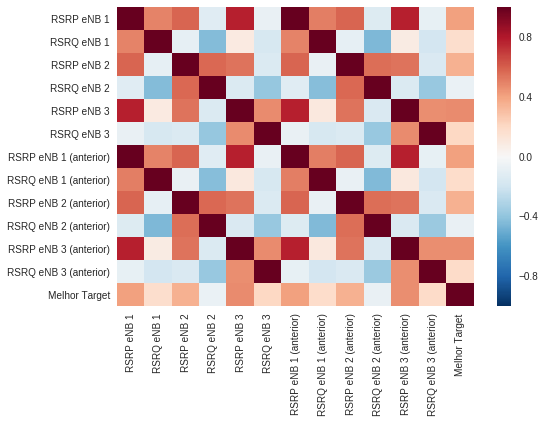

In [11]:
import seaborn as sns
features = data[['rsrp1','rsrq1','rsrp2','rsrq2','rsrp3','rsrq3','previousrsrp1','previousrsrq1','previousrsrp2','previousrsrq2','previousrsrp3','previousrsrq3', 'best_output']]
features = features.rename(columns={'rsrp1': 'RSRP eNB 1', 'rsrq1': 'RSRQ eNB 1', 'rsrp2': 'RSRP eNB 2', 'rsrq2': 'RSRQ eNB 2', 'rsrp3': 'RSRP eNB 3', 'rsrq3': 'RSRQ eNB 3', 'previousrsrp1': 'RSRP eNB 1 (anterior)', 'previousrsrq1': 'RSRQ eNB 1 (anterior)', 'previousrsrp2': 'RSRP eNB 2 (anterior)', 'previousrsrq2': 'RSRQ eNB 2 (anterior)', 'previousrsrp3': 'RSRP eNB 3 (anterior)', 'previousrsrq3': 'RSRQ eNB 3 (anterior)', 'best_output': 'Melhor Target'})
sns.heatmap(features.corr())

In [12]:
param_test = {'hidden_layer_sizes': [(i) for i in range(1,101)]}

### Estratégia 1

In [13]:
# A: Download Completo ou Incompleto (para todas as amostras)
nn1_a_input = data[['rsrp1','rsrq1','rsrp2','rsrq2','rsrp3','rsrq3','previousrsrp1','previousrsrq1','previousrsrp2','previousrsrq2','previousrsrp3','previousrsrq3']]

# NN A para T2
nn1_a0_output = (data.downloadTimeT2<100).astype(int)
nn1_a0 = GridSearchCV(estimator=MLPClassifier(solver='lbfgs', random_state=1, validation_fraction=0.25), param_grid=param_test, cv=5, scoring='roc_auc')
nn1_a0.fit(nn1_a_input.as_matrix(), nn1_a0_output);

print (nn1_a0.best_params_)
print ((nn1_a0.predict(nn1_a_input)==(data.downloadTimeT2<100).astype(int)).sum()/data.shape[0])

# NN A para T3
nn1_a1_output = (data.downloadTimeT3<100).astype(int)
nn1_a1 = GridSearchCV(estimator=MLPClassifier(solver='lbfgs', random_state=1, validation_fraction=0.25), param_grid=param_test, cv=5, scoring='roc_auc')
nn1_a1.fit(nn1_a_input.as_matrix(), nn1_a1_output);

print (nn1_a1.best_params_)
print ((nn1_a1.predict(nn1_a_input)==(data.downloadTimeT3<100).astype(int)).sum()/data.shape[0])

{'hidden_layer_sizes': 1}
0.79
{'hidden_layer_sizes': 1}
0.7525


In [14]:
# B: Tempo de Download (para amostras em que ambos os targets completam o download)
nn1_b_input = data[(data.downloadTimeT2<100)&(data.downloadTimeT3<100)][['rsrp1','rsrq1','rsrp2','rsrq2','rsrp3','rsrq3','previousrsrp1','previousrsrq1','previousrsrp2','previousrsrq2','previousrsrp3','previousrsrq3']]
# NN B para T2
nn1_b0_output = data[(data.downloadTimeT2<100)&(data.downloadTimeT3<100)].downloadTimeT2
nn1_b0 = GridSearchCV(estimator=MLPRegressor(solver='lbfgs', random_state=1, validation_fraction=0.25), param_grid=param_test, cv=5)
nn1_b0.fit(nn1_b_input.as_matrix(), nn1_b0_output);

print (nn1_b0.best_params_)
print (mean_squared_error(nn1_b0.predict(nn1_b_input),data[(data.downloadTimeT2<100)&(data.downloadTimeT3<100)].downloadTimeT2))

# NN B para T3
nn1_b1_output = data[(data.downloadTimeT2<100)&(data.downloadTimeT3<100)].downloadTimeT3
nn1_b1 = GridSearchCV(estimator=MLPRegressor(solver='lbfgs', random_state=1, validation_fraction=0.25), param_grid=param_test, cv=5)
nn1_b1.fit(nn1_b_input.as_matrix(), nn1_b1_output);

print (nn1_b1.best_params_)
print (mean_squared_error(nn1_b1.predict(nn1_b_input),data[(data.downloadTimeT2<100)&(data.downloadTimeT3<100)].downloadTimeT3))

{'hidden_layer_sizes': 5}
38.5043609087
{'hidden_layer_sizes': 6}
71.7443021468


In [15]:
# C: RxBytes (para amostras em que ambos os targets não completam o download)
nn1_c_input = data[(data.downloadTimeT2>=100)&(data.downloadTimeT3>=100)][['rsrp1','rsrq1','rsrp2','rsrq2','rsrp3','rsrq3','previousrsrp1','previousrsrq1','previousrsrp2','previousrsrq2','previousrsrp3','previousrsrq3']]
# NN B para T2
nn1_c0_output = data[(data.downloadTimeT2>=100)&(data.downloadTimeT3>=100)].rxBytesT2
nn1_c0 = GridSearchCV(estimator=MLPRegressor(solver='lbfgs', random_state=1, validation_fraction=0.25), param_grid=param_test, cv=5)
nn1_c0.fit(nn1_c_input.as_matrix(), nn1_c0_output);

print (nn1_c0.best_params_)
print (mean_squared_error(nn1_c0.predict(nn1_c_input),data[(data.downloadTimeT2>=100)&(data.downloadTimeT3>=100)].rxBytesT2))


# NN B para T3
nn1_c1_output = data[(data.downloadTimeT2>=100)&(data.downloadTimeT3>=100)].rxBytesT3
nn1_c1 = GridSearchCV(estimator=MLPRegressor(solver='lbfgs', random_state=1, validation_fraction=0.25), param_grid=param_test, cv=5)
nn1_c1.fit(nn1_c_input.as_matrix(), nn1_c1_output);

print (nn1_c1.best_params_)
print (mean_squared_error(nn1_c1.predict(nn1_c_input),data[(data.downloadTimeT2>=100)&(data.downloadTimeT3>=100)].rxBytesT3))

{'hidden_layer_sizes': 4}
8.57841512911e+12
{'hidden_layer_sizes': 4}
9.85403706978e+12


In [16]:
def nn1_func(row):
    nn1_input = row[['rsrp1','rsrq1','rsrp2','rsrq2','rsrp3','rsrq3','previousrsrp1','previousrsrq1','previousrsrp2','previousrsrq2','previousrsrp3','previousrsrq3']].values.reshape(1, -1)
    # Nível 1A
    # se o downloadTime previsto é menor que 100 para T2 e T3, ambos os targets completam o download
    if ((nn1_a0.predict(nn1_input)==1)&(nn1_a1.predict(nn1_input)==1)):
        # Nível 2B
        # o melhor output será aquele para o qual o downloadTime previsto é menor
        if (nn1_b0.predict(nn1_input)<=nn1_b1.predict(nn1_input)):
            return 0
        else:
            return 1
    
    # se o downloadTime previsto é menor que 100 apenas para um dos targets, só um deles completa o download
    elif ((nn1_a0.predict(nn1_input)==1)|(nn1_a1.predict(nn1_input)==1)):
        # o melhor output será aquele para o qual o downloadTime previsto é menor que 100
        if (nn1_a0.predict(nn1_input)==1):
            return 0
        else:
            return 1
        
    # se o downloadTime previsto é menor que 100 para ambos os targets
    elif ((nn1_a0.predict(nn1_input)==0)&(nn1_a1.predict(nn1_input)==0)):
        # o melhor output será aquele para o qual o rxBytes previsto é maior
        if (nn1_c0.predict(nn1_input)>=nn1_c1.predict(nn1_input)):
            return 0
        else:
            return 1      
        
((nn1_a_input.apply(nn1_func, axis=1)==data.best_output).sum())/data.best_output.size        

0.59624999999999995

### Estratégia 2

In [17]:
# A: Download Completo ou Incompleto (para todas as amostras)

# NN A para T2
nn2_a0_input = data[['rsrp2','rsrq2','previousrsrp2','previousrsrq2']]
nn2_a0_output = (data.downloadTimeT2<100).astype(int)
nn2_a0 = GridSearchCV(estimator=MLPClassifier(solver='lbfgs', random_state=1, validation_fraction=0.25), param_grid=param_test, scoring='roc_auc', cv=5)
nn2_a0.fit(nn2_a0_input.as_matrix(), nn2_a0_output);

print (nn2_a0.best_params_)
print ((nn2_a0.predict(nn2_a0_input)==(data.downloadTimeT2<100).astype(int)).sum()/data.shape[0])


# NN A para T3
nn2_a1_input = data[['rsrp3','rsrq3','previousrsrp3','previousrsrq3']]
nn2_a1_output = (data.downloadTimeT3<100).astype(int)
nn2_a1 = GridSearchCV(estimator=MLPClassifier(solver='lbfgs', random_state=1, validation_fraction=0.25), param_grid=param_test, scoring='roc_auc', cv=5)
nn2_a1.fit(nn2_a1_input.as_matrix(), nn2_a1_output);

print (nn2_a1.best_params_)
print ((nn2_a1.predict(nn2_a1_input)==(data.downloadTimeT3<100).astype(int)).sum()/data.shape[0])

{'hidden_layer_sizes': 6}
0.74875
{'hidden_layer_sizes': 4}
0.73625


In [18]:
# B: Tempo de Download (para amostras em que ambos os targets completam o download)

param_test = {'hidden_layer_sizes':[(i) for i in range(1,101)]}

# NN B para T2
nn2_b0_input = data[(data.downloadTimeT2<100)&(data.downloadTimeT3<100)][['rsrp2','rsrq2','previousrsrp2','previousrsrq2']]
nn2_b0_output = data[(data.downloadTimeT2<100)&(data.downloadTimeT3<100)].downloadTimeT2
nn2_b0 = GridSearchCV(estimator=MLPRegressor(solver='lbfgs', random_state=1, validation_fraction=0.25), param_grid=param_test, cv=5)
nn2_b0.fit(nn2_b0_input.as_matrix(), nn2_b0_output);

print (nn2_b0.best_params_)
print (mean_squared_error(nn2_b0.predict(nn2_b0_input),data[(data.downloadTimeT2<100)&(data.downloadTimeT3<100)].downloadTimeT2))


# NN B para T3
nn2_b1_input = data[(data.downloadTimeT2<100)&(data.downloadTimeT3<100)][['rsrp3','rsrq3','previousrsrp3','previousrsrq3']]
nn2_b1_output = data[(data.downloadTimeT2<100)&(data.downloadTimeT3<100)].downloadTimeT3
nn2_b1 = GridSearchCV(estimator=MLPRegressor(solver='lbfgs', random_state=1, validation_fraction=0.25), param_grid=param_test, cv=5)
nn2_b1.fit(nn2_b1_input.as_matrix(), nn2_b1_output);

print (nn2_b1.best_params_)
print (mean_squared_error(nn2_b1.predict(nn2_b1_input),data[(data.downloadTimeT2<100)&(data.downloadTimeT3<100)].downloadTimeT3))

{'hidden_layer_sizes': 11}
56.6167803607
{'hidden_layer_sizes': 49}
109.370451953


In [19]:
# C: Bytes Recebidos (para amostras em que ambos os targets não completam o download)

# NN C para T2
nn2_c0_input = data[(data.downloadTimeT2>=100)&(data.downloadTimeT3>=100)][['rsrp2','rsrq2','previousrsrp2','previousrsrq2']]
nn2_c0_output = data[(data.downloadTimeT2>=100)&(data.downloadTimeT3>=100)].rxBytesT2
nn2_c0 = GridSearchCV(estimator=MLPRegressor(solver='lbfgs', random_state=1, validation_fraction=0.25), param_grid=param_test, cv=5)
nn2_c0.fit(nn2_c0_input.as_matrix(), nn2_c0_output);

print (nn2_c0.best_params_)
print (mean_squared_error(nn2_c0.predict(nn2_c0_input),data[(data.downloadTimeT2>=100)&(data.downloadTimeT3>=100)].rxBytesT2))

# NN C para T3
nn2_c1_input = data[(data.downloadTimeT2>=100)&(data.downloadTimeT3>=100)][['rsrp3','rsrq3','previousrsrp3','previousrsrq3']]
nn2_c1_output = data[(data.downloadTimeT2>=100)&(data.downloadTimeT3>=100)].rxBytesT3
nn2_c1 = GridSearchCV(estimator=MLPRegressor(solver='lbfgs', random_state=1, validation_fraction=0.25), param_grid=param_test, cv=5)
nn2_c1.fit(nn2_c1_input.as_matrix(), nn2_c1_output);

print (nn2_c1.best_params_)
print (mean_squared_error(nn2_c1.predict(nn2_c1_input),data[(data.downloadTimeT2>=100)&(data.downloadTimeT3>=100)].rxBytesT3))

{'hidden_layer_sizes': 10}
1.2844076538e+13
{'hidden_layer_sizes': 6}
1.58266051267e+13


In [20]:
def nn2_func(row):
    nn2_a0_input = row[['rsrp2','rsrq2','previousrsrp2','previousrsrq2']].values.reshape(1, -1)
    nn2_a1_input = row[['rsrp3','rsrq3','previousrsrp3','previousrsrq3']].values.reshape(1, -1)
    
    # Nível 1A
    # se ambos os targets completam o download
    if ((nn2_a0.predict(nn2_a0_input)==1)&(nn2_a1.predict(nn2_a1_input)==1)):
        # Nível 2B
        # o melhor output será aquele para o qual o downloadTime previsto é menor
        nn2_b0_input = nn2_a0_input
        nn2_b1_input = nn2_a0_input
        if (nn2_b0.predict(nn2_b0_input)<=nn2_b1.predict(nn2_b1_input)):
            return 0
        else:
            return 1
    
    # se apenas um dos targets completa o download
    elif ((nn2_a0.predict(nn2_a0_input)==1)|(nn2_a1.predict(nn2_a1_input)==1)):
        # o melhor output será aquele que completa o download, segundo a previsão
        if (nn2_a0.predict(nn2_a0_input)==1):
            return 0
        else:
            return 1
        
    # se apenas nenhum dos targets completa o download
    elif ((nn2_a0.predict(nn2_a0_input)==0)&(nn2_a1.predict(nn2_a1_input)==0)):
        # o melhor output será aquele para o qual o rxBytes previsto é maior
        nn2_c0_input = nn2_a0_input
        nn2_c1_input = nn2_a0_input
        if (nn2_c0.predict(nn2_c0_input)>=nn2_c1.predict(nn2_c1_input)):
            return 0
        else:
            return 1        
        
((data.apply(nn2_func, axis=1)==data.best_output).sum())/data.best_output.size

0.53874999999999995

### Estratégia 3

In [21]:
nn3_input = data[['rsrp1','rsrq1','rsrp2','rsrq2','rsrp3','rsrq3','previousrsrp1','previousrsrq1','previousrsrp2','previousrsrq2','previousrsrp3','previousrsrq3']]
nn3_output = data.best_output

nn3 = GridSearchCV(estimator=MLPClassifier(solver='lbfgs', random_state=1, validation_fraction=0.25), param_grid=param_test, cv=5, scoring='roc_auc')

nn3.fit(nn3_input.as_matrix(), nn3_output)

def nn3_func(row):
    nn3_input_ = row[['rsrp1','rsrq1','rsrp2','rsrq2','rsrp3','rsrq3','previousrsrp1','previousrsrq1','previousrsrp2','previousrsrq2','previousrsrp3','previousrsrq3']].values.reshape(1, -1)
    return nn3.predict(nn3_input_)[0]

print (nn3.best_params_)
print (((nn3_input.apply(nn3_func, axis=1)==data.best_output).sum())/data.best_output.size)

{'hidden_layer_sizes': 4}
0.7775


In [22]:
teste['best_choice_download_complete'] = teste.apply(lambda x: download_complete(x, column='best_output'), axis=1)
teste['best_choice_download_time'] = teste.apply(lambda x: download_time(x, column='best_output'), axis=1)
teste['best_choice_throughput'] = teste.apply(lambda x: throughput(x, column='best_output'), axis=1)

In [23]:
teste['nn1'] = teste.apply(nn1_func, axis=1)
teste['nn1_download_complete'] = teste.apply(lambda x: download_complete(x, column='nn1'), axis=1)
teste['nn1_download_time'] = teste.apply(lambda x: download_time(x, column='nn1'), axis=1)
teste['nn1_throughput'] = teste.apply(lambda x: throughput(x, column='nn1'), axis=1)

In [24]:
teste['nn2'] = teste.apply(nn2_func, axis=1)
teste['nn2_download_complete'] = teste.apply(lambda x: download_complete(x, column='nn2'), axis=1)
teste['nn2_download_time'] = teste.apply(lambda x: download_time(x, column='nn2'), axis=1)
teste['nn2_throughput'] = teste.apply(lambda x: throughput(x, column='nn2'), axis=1)

In [25]:
teste['nn3'] = teste.apply(nn3_func, axis=1)
teste['nn3_download_complete'] = teste.apply(lambda x: download_complete(x, column='nn3'), axis=1)
teste['nn3_download_time'] = teste.apply(lambda x: download_time(x, column='nn3'), axis=1)
teste['nn3_throughput'] = teste.apply(lambda x: throughput(x, column='nn3'), axis=1)


### Estratégias Clássicas

In [26]:
teste['a2a4rsrp'] = teste.apply(a2a4rsrp, axis=1)
teste['a2a4rsrp_download_complete'] = teste.apply(lambda x: download_complete(x, column='a2a4rsrp'), axis=1)
teste['a2a4rsrp_download_time'] = teste.apply(lambda x: download_time(x, column='a2a4rsrp'), axis=1)
teste['a2a4rsrp_throughput'] = teste.apply(lambda x: throughput(x, column='a2a4rsrp'), axis=1)

In [27]:
def func(row):
    if (row.downloadTime<100):
        return row.downloadTime
    
teste['a3rsrp_download_complete'] = (a3rsrp_teste.downloadTime<100).astype(int)
teste['a3rsrp_download_time'] = a3rsrp_teste.apply((lambda x: func(x)), axis=1)
teste['a3rsrp_throughput'] = (a3rsrp_teste.rxBytes/a3rsrp_teste.downloadTime)*8/1e6

teste['a2a4rsrq_download_complete'] = (a2a4rsrq_teste.downloadTime<100).astype(int)
teste['a2a4rsrq_download_time'] = a2a4rsrq_teste.apply((lambda x: func(x)), axis=1)
teste['a2a4rsrq_throughput'] = (a2a4rsrq_teste.rxBytes/a2a4rsrq_teste.downloadTime)*8/1e6

#### Resultados - Sem Shadowing

In [28]:
estrategias = ['a2a4rsrp', 'a2a4rsrq', 'a3rsrp', 'nn1', 'nn2', 'nn3', 'best_choice']

results_ss = {}
casas = 3
for estrategia in estrategias:
    #print("\n\n", estrategia)
    #print("- Geral:")
    #print("Percentual de Downloads Completos: ", (teste[estrategia+"_download_complete"].sum()/teste.index.size)*100, "%")
    #print("Tempo Médio de Download para os Downloads Completos: ", teste[estrategia+"_download_time"].mean(), "s")
    #print("Throughput Médio: ", teste[estrategia+"_throughput"].mean(), "Mbps")
    #print("- Para a região central [-30,0]:")
    #print("Percentual de Downloads Completos: ", (teste[(teste.angle>-30) & (teste.angle<0)][estrategia+"_download_complete"].sum()/teste[(teste.angle>-30) & (teste.angle<0)].index.size)*100, "%")
    #print("Tempo Médio de Download para os Downloads Completos: ", teste[(teste.angle>-30) & (teste.angle<0)][estrategia+"_download_time"].mean(), "s")
    #print("Throughput Médio: ", teste[(teste.angle>-30) & (teste.angle<0)][estrategia+"_throughput"].mean(), "Mbps")
    results_ss[estrategia] = []
    results_ss[estrategia].append(round((teste[estrategia+"_download_complete"].sum()/teste.index.size)*100,casas))
    results_ss[estrategia].append(round(teste[estrategia+"_download_time"].mean(),casas))
    results_ss[estrategia].append(round(teste[estrategia+"_throughput"].mean(),casas))
    results_ss[estrategia].append(round((teste[(teste.angle>-30) & (teste.angle<0)][estrategia+"_download_complete"].sum()/teste[(teste.angle>-30) & (teste.angle<0)].index.size)*100,casas))
    results_ss[estrategia].append(round(teste[(teste.angle>-30) & (teste.angle<0)][estrategia+"_download_time"].mean(),casas))
    results_ss[estrategia].append(round(teste[(teste.angle>-30) & (teste.angle<0)][estrategia+"_throughput"].mean(),casas))

#### Resultados para o conjunto de teste - OhBuildings com shadowing

#### Geral

|   |A2A4RSRP|A2A4RSRQ|A3RSRP|NN1|NN2|NN3|BEST CHOICE|
|---|---|---|---|---|---|---|---|
|Downloads completos (%)|{{results_ss['a2a4rsrp'][0]}}|{{results_ss['a2a4rsrq'][0]}}|{{results_ss['a3rsrp'][0]}}|{{results_ss['nn1'][0]}}|{{results_ss['nn2'][0]}}|{{results_ss['nn3'][0]}}|{{results_ss['best_choice'][0]}}|
|Tempo médio de download para os downloads completos (s)|{{results_ss['a2a4rsrp'][1]}}|{{results_ss['a2a4rsrq'][1]}}|{{results_ss['a3rsrp'][1]}}|{{results_ss['nn1'][1]}}|{{results_ss['nn2'][1]}}|{{results_ss['nn3'][1]}}|{{results_ss['best_choice'][1]}}|
|Throughput médio (Mbps)|{{results_ss['a2a4rsrp'][2]}}|{{results_ss['a2a4rsrq'][2]}}|{{results_ss['a3rsrp'][2]}}|{{results_ss['nn1'][2]}}|{{results_ss['nn2'][2]}}|{{results_ss['nn3'][2]}}|{{results_ss['best_choice'][2]}}|

#### Para a região central [-30,0]

|   |A2A4RSRP|A2A4RSRQ|A3RSRP|NN1|NN2|NN3|BEST CHOICE|
|---|---|---|---|---|---|---|---|
|Downloads completos (%)|{{results_ss['a2a4rsrp'][3]}}|{{results_ss['a2a4rsrq'][3]}}|{{results_ss['a3rsrp'][3]}}|{{results_ss['nn1'][3]}}|{{results_ss['nn2'][3]}}|{{results_ss['nn3'][3]}}|{{results_ss['best_choice'][3]}}|
|Tempo médio de download para os downloads completos (s)|{{results_ss['a2a4rsrp'][4]}}|{{results_ss['a2a4rsrq'][4]}}|{{results_ss['a3rsrp'][4]}}|{{results_ss['nn1'][4]}}|{{results_ss['nn2'][4]}}|{{results_ss['nn3'][4]}}|{{results_ss['best_choice'][4]}}|
|Throughput médio (Mbps)|{{results_ss['a2a4rsrp'][5]}}|{{results_ss['a2a4rsrq'][5]}}|{{results_ss['a3rsrp'][5]}}|{{results_ss['nn1'][5]}}|{{results_ss['nn2'][5]}}|{{results_ss['nn3'][5]}}|{{results_ss['best_choice'][5]}}|